# $8^{th}$ exercises
## Notebook setup
#### Used libraries

In [65]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb as rgb
from math import sin, cos, radians
from mpl_toolkits.mplot3d import Axes3D
from numpy import exp
from scipy.integrate import quad

#### Reading and printing config files

In [36]:
#Load and print config files
def LoadConf(path,T=int):
    d={}
    with open(path) as file:
        for line in file:
            (directive,key, val) = line.split()
            if(directive=="#define"): d[key] = T(val)
    return d

def PrintConf(d):
    for key, val in d.items(): print("{0:<19}{1}".format(key,val))
        
#Plot shortcuts
def PlotSetup():
    plt.axes().set_facecolor(bg1)
    plt.grid(alpha=0.3)

def MultiplotSetup(fig,r,c):
    for i in range(r*c):
        plt.subplot(r,c,i+1)
        fig.axes[i].set_facecolor(bg1)
        plt.grid(alpha=0.3) 
    
def Legend():
    leg = plt.legend(facecolor=bg2)
    for text in leg.get_texts():
        text.set_color(el1)
        
def Errbar1Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.plot(x,y,color=el1)
    
def Errbar2Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.vlines(x,y-2*e,y+2*e,color=er2,alpha=0.4, label="$2\sigma$")
    plt.plot(x,y,color=el1)

#### Colors

In [69]:
#background
bg1 = "#191724" 
bg2 = "#26233a" 
#elements
el1 = "#e0def4" 
el2 = "#f6c177" 
el3 = "#eb6f92" 
el4 = "#9ccfd8"
#errorbars
er1 = "#908caa"  
er2 = "#6e6a86"

## 08.1 Variational methods
### Introductory notes
Variational methods are a conceptually simple but powerful tool to find approximation to a quantum ground state. The observation behind these metods is the fact that
\begin{equation}
E_{gs} = min_H \frac{\langle \Psi| {\hat H} | \Psi \rangle}{\langle \Psi | \Psi \rangle}
\end{equation}
Where $H$ is the hilbert space and $\hat H$ the hamiltonian operator. It follows that by restricting our research of the minimum to a subset of $H$ we will found an upper bound to the ground state energy. Choosing a *good* subset we can hope for that upper bound to be close to the true $E_{gs}$. As an example, the famous Hartree-Fock equations are obtained taking advantage of this observation, by choosing as a subset the subspace spanned by slater determinants.

Let's focus on a potential of the form
$$
V(x) = x^4 - \frac{5}{2}x^2
$$
and elaborate on the concept of "good subset". This potential is even so we know that the ground state has to be even: if we choose a subset composed only by odd states theres no hope to get near the ground state -in fact we can't do any better than the first excited state! A good subset for example is the one composed by 
$$
\Psi_T^{\mu,\sigma^2}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$
a family of even wave function depending on two parameters. 

### Exercise goal
**Goal:** Fixing a state (that is: fixing $\mu$ and $\sigma^2$), we want to evaluate the expectation value of $\hat H$ using metropolis.
 
**Expectations:** we know for sure that what we find should not be lower than the ground state energy.

### Equilibration
We found that by taking delta as

In [54]:
conf_mrt2=LoadConf("in/081-conf_metro.inl",float)
PrintConf(conf_mrt2)

DELTA              3.0


the 50% empirical rule is fulfilled.

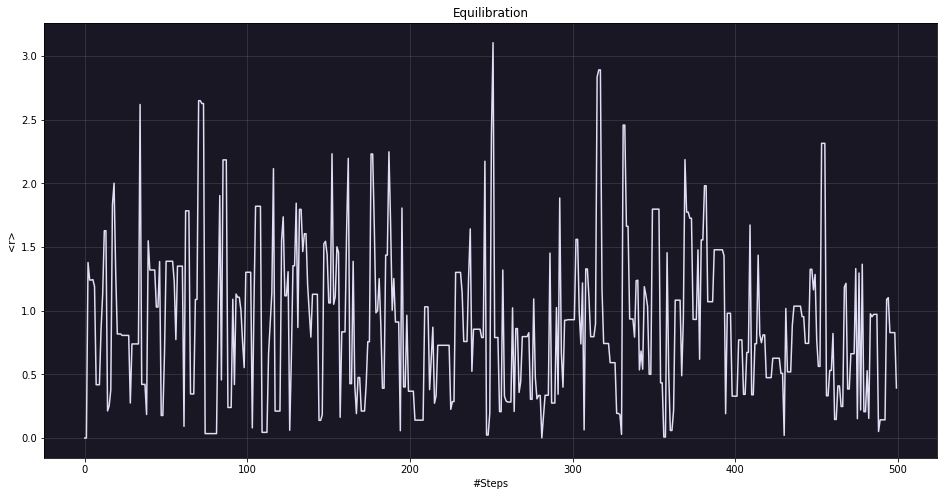

In [81]:
fig=plt.figure(figsize=(16, 8))
PlotSetup()

plt.title("Equilibration")
plt.xlabel('#Steps')
plt.ylabel('<r>')

data = np.genfromtxt("out/081-equi.csv", delimiter=",", skip_header=0)
x=data[:,0]
y=data[:,1]

plt.plot(x,y,c=el1)


plt.show()

### Energy evaluation

We fixed $\mu=1$, $\sigma=1$. For the datablocking we used `N_BLOCKS` blocks with `STEPS_PER_BLOCK` steps each -where: 

In [56]:
conf_db=LoadConf("in/081-conf_db.inl",int)
PrintConf(conf_db)

N_BLOCKS           100
STEPS_PER_BLOCK    100000


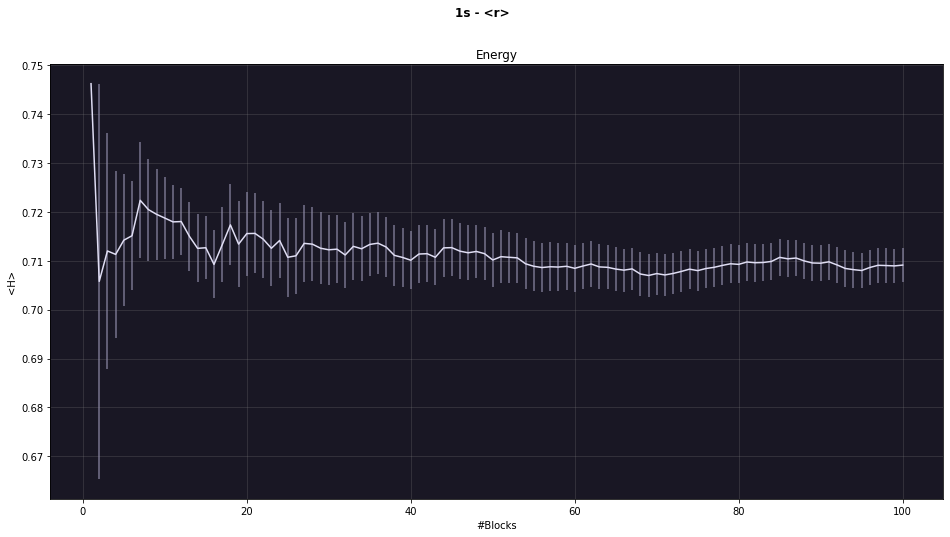

In [80]:
fig=plt.figure(figsize=(16, 8))
PlotSetup()
plt.suptitle('1s - <r>', weight='bold')


plt.title("Energy")
plt.xlabel('#Blocks')
plt.ylabel('<H>')

data = np.genfromtxt("out/081-energy.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,2]
e=data[:,3]

Errbar1Sigma(x,y,e)


plt.show()

## 08.2 Simulated annealing
### Introductory notes
Computationally, that of finding the ground state through variational methods is an optimization problem (where the cost function is the hamiltonian expectation value). As such it suffers from typical optimization difficulties, one above all the risk of being trapped in a local minima.

Simulated annealing takes inspiration from the physical process of slow cooling of a liquid until it crystallize -or we could rephrase it as: until energy reaches a minimum. The idea it that to embedd an optimization problem in an annealing problem by using the cost function $L(x)$ as the energy in the Boltzmann distribution
\begin{equation}
p(x)=\frac{e^{-\beta L(x)}}{Z}
\end{equation}
and by letting the parameter $\beta$ slowly growing with time. As $\beta$ grows solutions with low $L(x)$ are more and more preferred. Let's notice that SA has the two major components of metaheuristic algorithm: diversification, as for low $\beta$ we explore the whole space of solutions, and intensification since when $\beta$ is high we are focusing on a specific region of the space of solutions.

A foundamental role in simulated annealing is played by the annealing schedule $\{\beta_i,n_i\}$, the series of $\beta$ values and steps executed for each $\beta$. Overall the algorithm looks something like:
```
Evaluate the cost for an
initial solution L(x)
        |
        v
Consider the i-th step
of the schedule:            <------------|
(beta_i,n_i)                             |
        |                                |
        v                                |
Propose a new solution                   |
and evaluate its cost L(x') <--------|   |
        |                            |   |
        v                            |   |
Metropolis-like step:                |   |
IF L(x)>L(x') accept the             |   |
new solution                         |   |
ELSE accept the new solution         |   |
with probability p(x')/p(x)          |   |
        |                            |   |
        v                            |   |
Repeat n_i times            ---------|   |
        |                                |
        v                                |
Next step of the schedule   -------------| 

```

Let's focus on our case of interest. We have that the family of solution is even with respect to $\mu$. Since $\sigma^2$ is clearly greater than 0, we can impose the condition that the new solution should never have negative parameters, in order to restrict the space of research. This comes at a cost: we can't use a symmetric trial distribution, thus to validate the trial move we have to use the full metropolis test
\begin{equation}
\frac{T(\mu,\sigma^2|\mu_t,\sigma^2_t)}{T(\mu_t,\sigma^2_t|\mu,\sigma^2)}
\frac{p(\mu_t,\sigma^2_t)}{p(\mu,\sigma^2)}
\end{equation}
where $\mu_t$,$\sigma^2_t$ are the trial parameters we want to validate. We have to work out the ratio of trial distribution. The parameters evolve indipendently, so
\begin{equation}
T(\mu,\sigma^2|\mu_t,\sigma^2_t)=\frac{T(\mu,\sigma^2,\mu_t,\sigma^2_t)}{T(\mu_t,\sigma^2_t)}=
\frac{T(\mu,\mu_t)T(\sigma^2,\sigma^2_t)}{T(\mu_t)T(\sigma^2_t)}=T(\mu|\mu_t)T(\sigma^2|\sigma^2_t)
\end{equation}
Thus we can call $x$ a generic parameter and work with that. A trial distribution fulfilling our requirement is a uniform distribution of variance $\delta$ and centered on $x$ such that if the extracted value $y$ is smaller than zero, it sign is changed. Such a distribution have the following expression:
\begin{equation}
T(y|x)=
\begin{cases}
& 1 - \frac{x}{\delta}   \quad      \text{if}\quad y\in (0,\delta-x) \\
& \frac{x}{\delta} \quad\quad\,\,\, \text{if}\quad y\in [\delta-x,x+\delta) \\
& 0 \quad\quad\quad elsewhere
\end{cases}
\end{equation}

### Implementation notes
When we change the parameters we are changing the pdf we want to sample and so we have to re-tune the metropolis algorithm. In order to address this problem at each SA step, we take advantage of the method `AutoTune` in the metropolis class (`lib/Metropolis`). It takes in input a starting point, a tollerance interval and a number of steps and tries to change the metropolis parameter $\delta$ until the acceptance enters in the tollerance interval around the ideal value of $50\%$ acceptance (acceptance is evaluated by evolving the starting point for the number of steps given as input - so `AutoTune` also performs equilibration). To reach this goal the method is divided in two parts.
The first part aims to find a good interval in which the correct $\delta$ could be found. Suppose we are starting from a $\delta$ for which the acceptance is lower than $50\%$. We then multiply that $\delta$ by a value smaller than 1 until we find an acceptance bigger than $50\%$ (if the starting value gives an acceptance bigger than $50\%$ we do the same multiplying by a number smaller than 1). If in this process we find a $\delta$ whose acceptance is in the tollerance interval we stop, otherwise we go on with the second part. Here we simply use the bisection method on the interval we found until we enter in the tollerance interval.

Some observations:
1. The second part is necessary to avoid the risk, that comes by scaling delta of a constant factor, of finding ourself in an infinite ping-pong between values with accepance greater and smaller than $50\%$
2. Since the acceptance is evaluated on a limited number of steps, usually the true acceptance will be different from the one found. For this reason is safe to use a smaller tollerance interval then the one we really need
3. In all our trials, for not-too-small acceptance interval the first part of the method was enough to tune properly the metropolis.

As regards the annealing schedule we followed two principles: 
- exponential scaling of $\beta$: $\beta_{i+1}=k\beta_i$ in order to allow for slow cooling in the firs phases of the algorithm while still reaching low enouogh temperature in a reasonable amount of time.
- steps growing with $\beta$ in order to spend more time where the acceptance rate is lower.

The exact schedule we used is
\begin{equation}
\begin{cases}
        &\beta_i=1.2 \times \beta_{i-1}\quad\quad n_i=n_0+\text{int}(1.33\times i) \\
        &\beta_0=1\quad\quad\quad\quad\quad n_0=10
\end{cases}
\end{equation}
where $i<30$. There's no reason behind the numbers we choose other than having at the end of the schedule $\beta\simeq 200$ and $n=50$.

### Solution

We used the following parameters to perform the optimization:

In [57]:
conf_mrt2=LoadConf("in/082-conf_metro.inl",float)
PrintConf(conf_mrt2)

DELTA_EN           3.0
DELTA_SA           0.25


Where `DELTA_SA` is the maximum step the parameters can make and `DELTA_EN` is the starting $\delta$ given to the metropolis object that had to perform the energy evaluation.

For the datablocking we used `N_BLOCKS` blocks with `STEPS_PER_BLOCK` steps each -where: 

In [58]:
conf_db=LoadConf("in/081-conf_db.inl",int)
PrintConf(conf_db)

N_BLOCKS           100
STEPS_PER_BLOCK    100000


#### Parameters trajectory

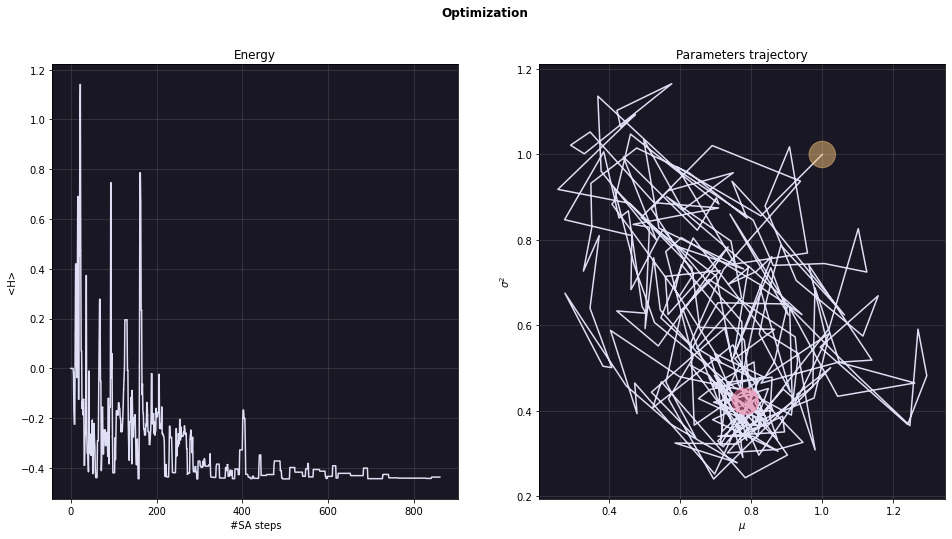

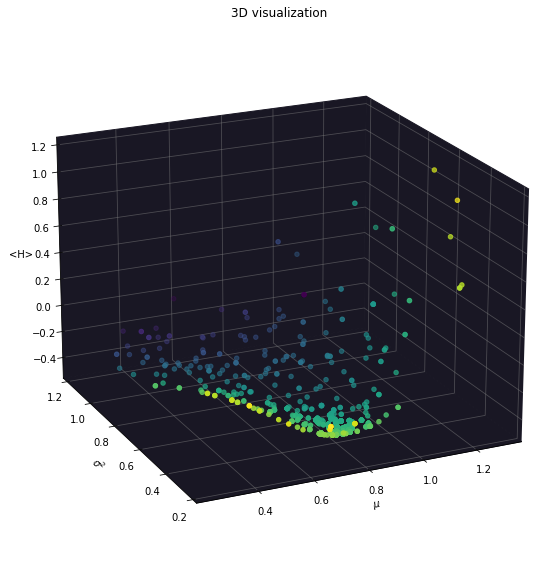

In [83]:
fig=plt.figure(figsize=(16, 8))
MultiplotSetup(fig,1,2)
plt.suptitle('Optimization', weight='bold')

plt.subplot(121)
plt.title("Energy")
plt.xlabel('#SA steps')
plt.ylabel('<H>')

data = np.genfromtxt("out/082-params.csv", delimiter=",", skip_header=1)
y=data[:,2]
e=data[:,3]
x=np.arange(0,862)

Errbar1Sigma(x,y,e)

plt.subplot(122)
plt.title("Parameters trajectory")
plt.xlabel('$\mu$')
plt.ylabel('$\sigma^2$')

data = np.genfromtxt("out/082-params.csv", delimiter=",", skip_header=1)
mu=data[:,0]
s2=data[:,1]

plt.plot(mu,s2,color=el1)
plt.scatter([mu[0],mu[-1]],[s2[0],s2[-1]],s=700,color=[el2,el3],alpha=0.5,zorder=5)

plt.show()

#3D scatter plot
fig=plt.figure(figsize=(10,10))
theta_d=20
phi_d=-115
theta_r=radians(theta_d)
phi_r=radians(phi_d)

ax = plt.axes(projection='3d')
plt.title("3D visualization")

data = np.genfromtxt("out/082-params.csv", delimiter=",", skip_header=0)

X=data[:,0]
Y=data[:,1]
Z=data[:,2]

ax.scatter(X, Y, Z, c=X*cos(theta_r)*cos(phi_r) +Y*cos(theta_r)*sin(phi_r) +Z*sin(theta_r),marker='o')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma^2$')
ax.set_zlabel('<H>')
ax.view_init(theta_d, phi_d)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.5)
ax.w_xaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_yaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_zaxis.set_pane_color(rgb(bg1)+(1,))

plt.show()

Here the yellow dot represent the starting parameters and the red dots the parameters obtained by completing the SA schedule.

#### Best energy extimation

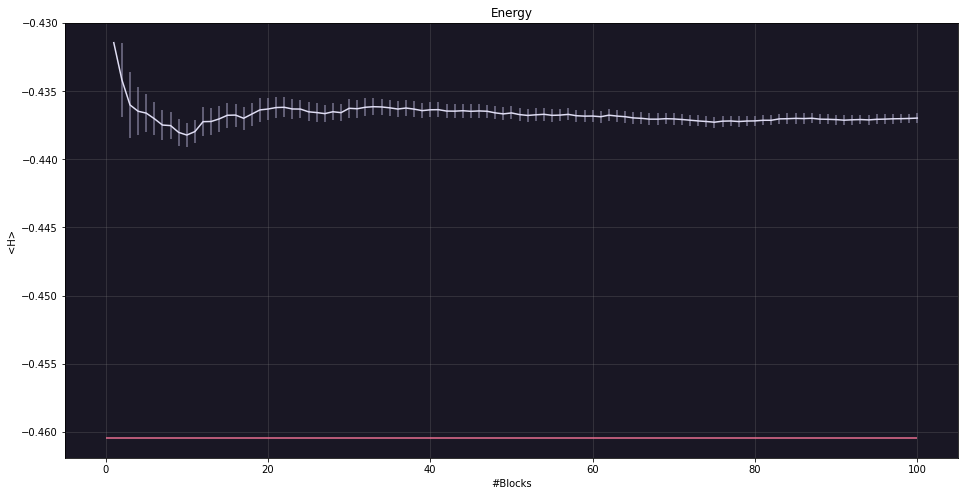

Ground state energy:  -0.436968 ± 0.000338893


In [85]:
fig=plt.figure(figsize=(16, 8))
PlotSetup()

plt.title("Energy")
plt.xlabel('#Blocks')
plt.ylabel('<H>')

data = np.genfromtxt("out/082-best_energy.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,2]
e=data[:,3]

Errbar1Sigma(x,y,e)
plt.hlines(-0.46046587969259045,0, conf_db["N_BLOCKS"],color=el3)


plt.show()

print("Ground state energy: ", y[-1],"±", e[-1])

#### Ground state wave function

Here we want to compare the module squared of:
- the true ground state wave function
- the analytical form of the approximated ground state wave function
- the approximated ground state wave function sampled by our algorithm

Let's first of all evaluate the true ground state

In [87]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi2 = (psi**2)/dx


We then evaluate the normalization (squared) of the analytical approximate solution

In [88]:
def psi2an (x):
    return (exp(-0.5*(x-mu[-1])**2/s2[-1])+exp(-0.5*(x+mu[-1])**2/s2[-1]))**2

norm2=quad(psi2an,-np.Infinity,np.Infinity)
print(norm2[0])

2.8436662712314456


And finally we are ready to make a comparison

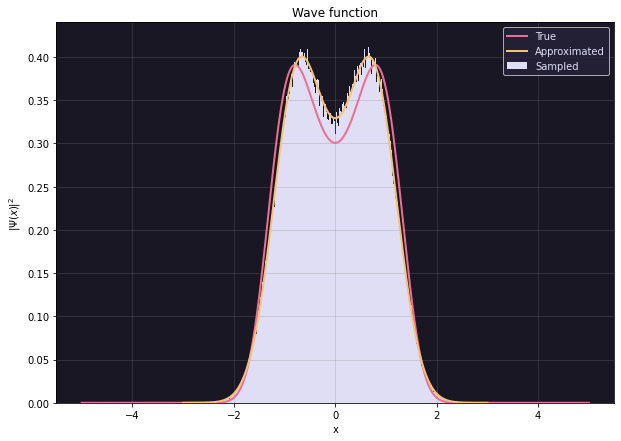

In [89]:
fig=plt.figure(figsize=(10, 7))
PlotSetup()
plt.title("Wave function")
plt.xlabel('x')
plt.ylabel('$|\Psi(x)|^2$')

xmin=-3
xmax=3
data = np.genfromtxt("out/082-points.dat")
xan=np.linspace(xmin,xmax,1000)

plt.plot(x,psi2[0],color=el3, label="True",linewidth=2)
plt.plot(xan,psi2an(xan)/norm2[0],color=el2, label="Approximated",linewidth=2)
plt.hist(data,1000,color=el1,density=True, label="Sampled")

Legend()

plt.show()

As we can see the sampled and the analytical approximate ground states coincides almost perfectly. They also approximate the true ground state quite well.

### Appendix: comparing different schedules 

We tried out three different schedules:
- **Schedule 1**:
\begin{equation}
\begin{cases}
        &\beta_i=1.2 \times \beta_{i-1}\quad\quad n_i=n_0 \\
        &\beta_0=1\quad\quad\quad\quad\quad n_0=25
\end{cases}
\end{equation}
- **Schedule 2**:
\begin{equation}
\begin{cases}
        &\beta_i=1.2 \times \beta_{i-1}\quad\quad n_i=n_0+\text{int}(1.33\times i) \\
        &\beta_0=1\quad\quad\quad\quad\quad n_0=10
\end{cases}
\end{equation}
- **Schedule 3**:
\begin{equation}
\begin{cases}
        &\beta_i=1.2 \times \beta_{i-1}\quad\quad n_i=n_0+\text{int}\Bigl(\frac{i^{1.5}}{3.9}\Bigr) \\
        &\beta_0=1\quad\quad\quad\quad\quad n_0=10
\end{cases}
\end{equation}

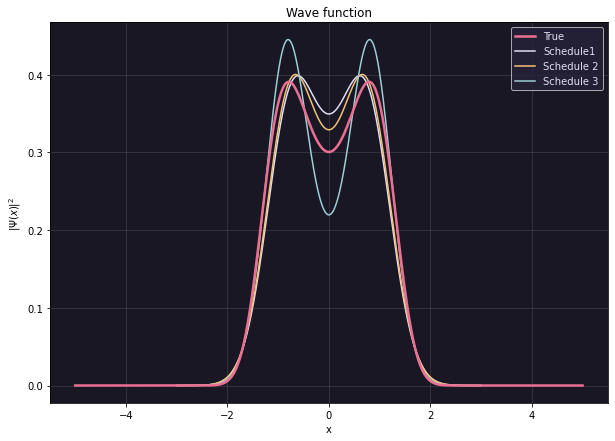

Schedule 1 - Energy: -0.429971 ± 0.000384832
Schedule 2 - Energy: -0.436968 ± 0.000338893
Schedule 3 - Energy: -0.430004 ± 0.000329651


In [91]:
fig=plt.figure(figsize=(10, 7))
PlotSetup()
plt.title("Wave function")
plt.xlabel('x')
plt.ylabel('$|\Psi(x)|^2$')

xmin=-3
xmax=3

#True
plt.plot(x,psi2[0],color=el3, label="True",linewidth=2.5,zorder=5)

xan=np.linspace(xmin,xmax,1000)
#Schedule 1
data = np.genfromtxt("store/const25-params.csv", delimiter=",", skip_header=1)
mu=data[:,0]
s2=data[:,1]
def psi2an (x):
    return (exp(-0.5*(x-mu[-1])**2/s2[-1])+exp(-0.5*(x+mu[-1])**2/s2[-1]))**2
norm2=quad(psi2an,-np.Infinity,np.Infinity)

plt.plot(xan,psi2an(xan)/norm2[0],color=el1, label="Schedule1")

#Schedule 2
data = np.genfromtxt("store/lin1.33-params.csv", delimiter=",", skip_header=1)
mu=data[:,0]
s2=data[:,1]
def psi2an (x):
    return (exp(-0.5*(x-mu[-1])**2/s2[-1])+exp(-0.5*(x+mu[-1])**2/s2[-1]))**2
norm2=quad(psi2an,-np.Infinity,np.Infinity)

plt.plot(xan,psi2an(xan)/norm2[0],color=el2, label="Schedule 2")

#Schedule 3
data = np.genfromtxt("store/exp1.5-params.csv", delimiter=",", skip_header=1)
mu=data[:,0]
s2=data[:,1]
def psi2an (x):
    return (exp(-0.5*(x-mu[-1])**2/s2[-1])+exp(-0.5*(x+mu[-1])**2/s2[-1]))**2
norm2=quad(psi2an,-np.Infinity,np.Infinity)

plt.plot(xan,psi2an(xan)/norm2[0],color=el4, label="Schedule 3")

Legend()

plt.show()

en1=np.genfromtxt("store/const25-energy.csv", delimiter=",", skip_header=1)[-1,2]
err1=np.genfromtxt("store/const25-energy.csv", delimiter=",", skip_header=1)[-1,3]
en2=np.genfromtxt("store/lin1.33-energy.csv", delimiter=",", skip_header=1)[-1,2]
err2=np.genfromtxt("store/lin1.33-energy.csv", delimiter=",", skip_header=1)[-1,3]
en3=np.genfromtxt("store/exp1.5-energy.csv", delimiter=",", skip_header=1)[-1,2]
err3=np.genfromtxt("store/exp1.5-energy.csv", delimiter=",", skip_header=1)[-1,3]

print("Schedule 1 - Energy:", en1,"±", err1)
print("Schedule 2 - Energy:", en2,"±", err2)
print("Schedule 3 - Energy:", en3,"±", err3)

Schedule 2 performs better than the others